## Domain:
* Multivariate time series

## Data source:
* MIMIC-III ICU encounters (n = 59,248)
* https://mimic.physionet.org/

## Variables (8):
* Heart rate
* Systolic BP
* Diastolic BP
* Mean arterial pressure
* Respiratory rate
* Temperature (C)
* SpO2
* Glucose

## Prediction task:
* Given first 24 hours of ICU data, predict eventual in-hospital mortality (Death = 1, Survival = 0)
* Binary classification

## Model:
* Recurrent neural network (RNN) with long short-term memory (LSTM)

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
engine = create_engine('postgresql:///mimic')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, GRU, CuDNNLSTM, CuDNNGRU, Masking, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1. Extract raw data from MIMIC-III database

In [2]:
%%time

df = pd.read_sql_query("""
SELECT
    icustay_id,
    time,
    (case when VitalID = 1 then valuenum else null end) as heart_rate,
    (case when VitalID = 2 then valuenum else null end) as sys_bp,
    (case when VitalID = 3 then valuenum else null end) as dia_bp,
    (case when VitalID = 4 then valuenum else null end) as mean_bp,
    (case when VitalID = 5 then valuenum else null end) as resp_rate,
    (case when VitalID = 6 then valuenum else null end) as temp,
    (case when VitalID = 7 then valuenum else null end) as spo2,
    (case when VitalID = 8 then valuenum else null end) as glucose

FROM
    (
        SELECT
            ce.icustay_id,
            ce.charttime as time,
            (case
                when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1
                when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2
                when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3
                when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4
                when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5
                when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6
                when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6
                when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7
                when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8
            else null end) as VitalID,
            case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum

        FROM
            icustays ie
            left join chartevents ce
            on ie.icustay_id = ce.icustay_id
            and ce.charttime >= ie.intime
            and ce.charttime < ie.intime + interval '1' day
            and ce.error IS DISTINCT FROM 1
        WHERE
            ce.itemid in (
                211, --"Heart Rate"
                220045, --"Heart Rate"
                51, -- Arterial BP [Systolic]
                442, -- Manual BP [Systolic]
                455, -- NBP [Systolic]
                6701, -- Arterial BP #2 [Systolic]
                220179, -- Non Invasive Blood Pressure systolic
                220050, -- Arterial Blood Pressure systolic
                8368, -- Arterial BP [Diastolic]
                8440, -- Manual BP [Diastolic]
                8441, -- NBP [Diastolic]
                8555, -- Arterial BP #2 [Diastolic]
                220180, -- Non Invasive Blood Pressure diastolic
                220051, -- Arterial Blood Pressure diastolic
                456, -- "NBP Mean"
                52, -- "Arterial BP Mean"
                6702, -- Arterial BP Mean #2
                443, -- Manual BP Mean(calc)
                220052, -- "Arterial Blood Pressure mean"
                220181, -- "Non Invasive Blood Pressure mean"
                225312, -- "ART BP mean"
                618, -- Respiratory Rate
                615, -- Resp Rate (Total)
                220210, -- Respiratory Rate
                224690, -- Respiratory Rate (Total)
                646, 220277, -- SpO2
                807, -- Fingerstick Glucose
                811, -- Glucose (70-105)
                1529, -- Glucose
                3745, -- BloodGlucose
                3744, -- Blood Glucose
                225664, -- Glucose finger stick
                220621, -- Glucose (serum)
                226537, -- Glucose (whole blood)
                223762, -- "Temperature Celsius"
                676, -- "Temperature C"
                223761, -- "Temperature Fahrenheit"
                678 -- "Temperature F"
            )
  ) p

ORDER BY icustay_id, time
""", con=engine)

CPU times: user 25.8 s, sys: 4.64 s, total: 30.5 s
Wall time: 3min 33s


In [3]:
print('# rows = %d' % len(df))
df[:5]

# rows = 10553011


,icustay_id,time,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,2181-11-25 19:07:00,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN
1,200001,2181-11-25 19:08:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN
2,200001,2181-11-25 19:08:00,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN
3,200001,2181-11-25 19:08:00,NaN,NaN,NaN,77.0,NaN,NaN,NaN,NaN
4,200001,2181-11-25 19:14:00,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN


## 2. Resample to 1-hour frequency

#### For each ICU stay, convert absolute time of each measurement to elapsed time from ICU admission

In [4]:
%%time
df['time'] = df.groupby('icustay_id')['time'].apply(lambda time: time - time.iloc[0])

CPU times: user 30.1 s, sys: 188 ms, total: 30.3 s
Wall time: 29.7 s


In [5]:
df[:5]

,icustay_id,time,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,00:00:00,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN
1,200001,00:01:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN
2,200001,00:01:00,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN
3,200001,00:01:00,NaN,NaN,NaN,77.0,NaN,NaN,NaN,NaN
4,200001,00:07:00,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN


#### For each ICU stay, calculate mean measurement values for each hour after ICU admission (0 < hours < 24)

In [6]:
%%time
df = df.groupby(['icustay_id', df['time']//pd.Timedelta('1 hour')]).mean().reset_index()

CPU times: user 2.14 s, sys: 40 ms, total: 2.18 s
Wall time: 1.07 s


In [7]:
df[:5]

,icustay_id,time,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,0,113.5,111.5,65.0,76.5,22.666667,37.277778,95.333333,NaN
1,200001,1,108.0,113.0,68.0,79.0,18.000000,NaN,98.000000,NaN
2,200001,2,110.0,116.0,68.0,79.0,27.000000,NaN,98.000000,118.0
3,200001,3,102.0,102.0,61.0,71.0,21.000000,37.666667,96.000000,NaN
4,200001,4,108.0,103.0,58.0,69.0,19.000000,NaN,94.000000,NaN


## 3. Fill in missing values

#### For each ICU stay and variable, if no measurement occurred in an interval, use the most recent measurement value (forward propagation)

In [8]:
df = df.groupby('icustay_id').ffill()

In [9]:
df[:5]

,icustay_id,time,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,0,113.5,111.5,65.0,76.5,22.666667,37.277778,95.333333,NaN
1,200001,1,108.0,113.0,68.0,79.0,18.000000,37.277778,98.000000,NaN
2,200001,2,110.0,116.0,68.0,79.0,27.000000,37.277778,98.000000,118.0
3,200001,3,102.0,102.0,61.0,71.0,21.000000,37.666667,96.000000,118.0
4,200001,4,108.0,103.0,58.0,69.0,19.000000,37.666667,94.000000,118.0


#### For remaining missing values, use first available measurement (backward propagation)

In [10]:
df = df.groupby('icustay_id').bfill()

In [11]:
df[:5]

,icustay_id,time,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,0,113.5,111.5,65.0,76.5,22.666667,37.277778,95.333333,118.0
1,200001,1,108.0,113.0,68.0,79.0,18.000000,37.277778,98.000000,118.0
2,200001,2,110.0,116.0,68.0,79.0,27.000000,37.277778,98.000000,118.0
3,200001,3,102.0,102.0,61.0,71.0,21.000000,37.666667,96.000000,118.0
4,200001,4,108.0,103.0,58.0,69.0,19.000000,37.666667,94.000000,118.0


## 4. Save data

In [12]:
df.to_csv('data/vitals.csv', index=None)

## 5. Extract and save mortality labels

In [13]:
labels = pd.read_sql_query("""
SELECT
    ie.icustay_id,
    adm.hospital_expire_flag as label
FROM
    icustays ie
    left join admissions adm
    on ie.hadm_id = adm.hadm_id
""", con=engine)

In [14]:
labels[:5]

,icustay_id,label
0,280836,1
1,206613,0
2,220345,0
3,249196,0
4,210407,0


In [15]:
labels.to_csv('data/vitals_labels.csv', index=None)

## 6. Example data plots

In [16]:
def plot(icustay_id, linewidth=3):
    fig = plt.figure(figsize=(20,5))
    ax = plt.gca()
    
    data = df[df['icustay_id'] == icustay_id]

    ax.plot(data['heart_rate'].values, label='Heart rate', linewidth=linewidth)
    ax.plot(data['sys_bp'].values, label='Systolic BP', linewidth=linewidth)
    ax.plot(data['dia_bp'].values, label='Diastolic BP', linewidth=linewidth)
    ax.plot(data['mean_bp'].values, label='Mean BP', linewidth=linewidth)
    ax.plot(data['resp_rate'].values, label='Respiratory rate', linewidth=linewidth)
    ax.plot(data['temp'].values, label='Temperature', linewidth=linewidth)
    ax.plot(data['spo2'].values, label='SpO2', linewidth=linewidth)
    ax.plot(data['glucose'].values, label='Glucose', linewidth=linewidth)
    
    ax.set_xlabel('Hours After ICU Admission')
    ax.set_xlim([0,23])
    
    legend = ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), fontsize=12)
    
    plt.show()

In [17]:
icustay_ids = list(df['icustay_id'].unique())
icustay_ids[:5]

[200001, 200003, 200006, 200007, 200009]

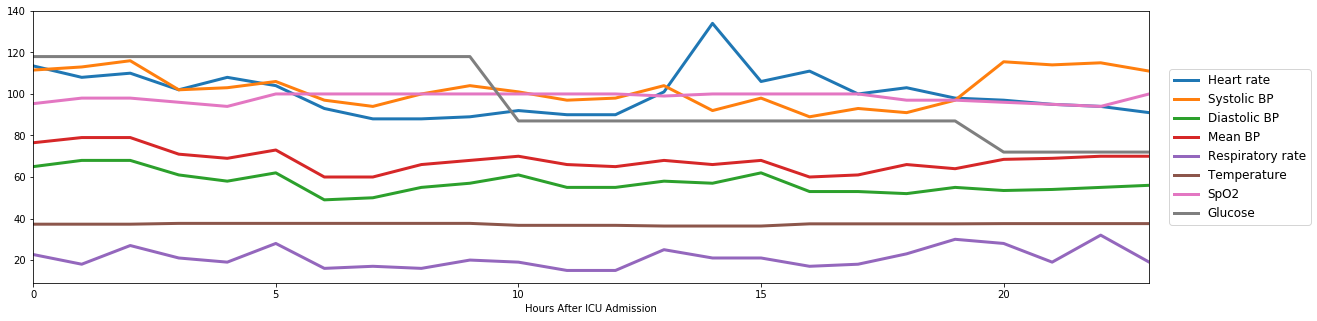

In [18]:
plot(200001)

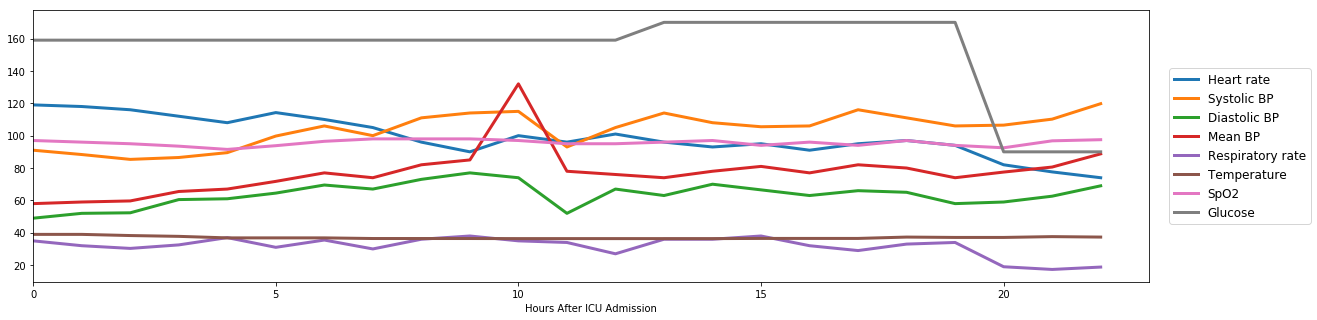

In [19]:
plot(200003)

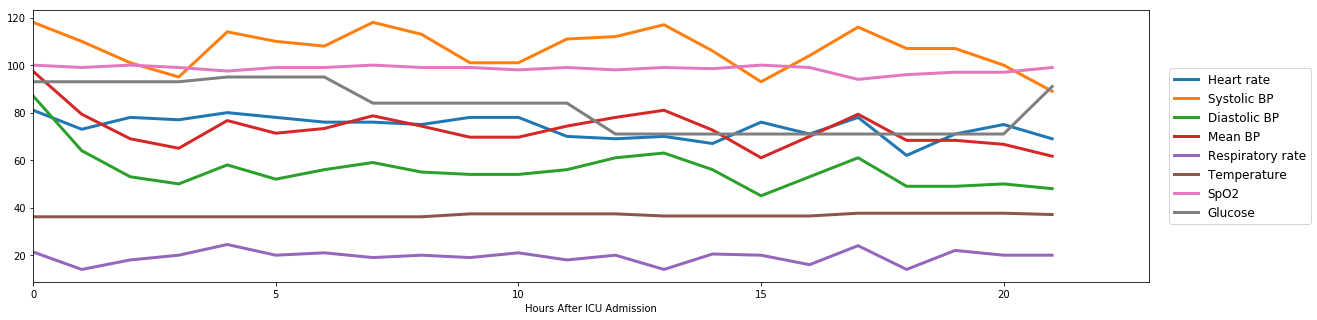

In [20]:
plot(200006)

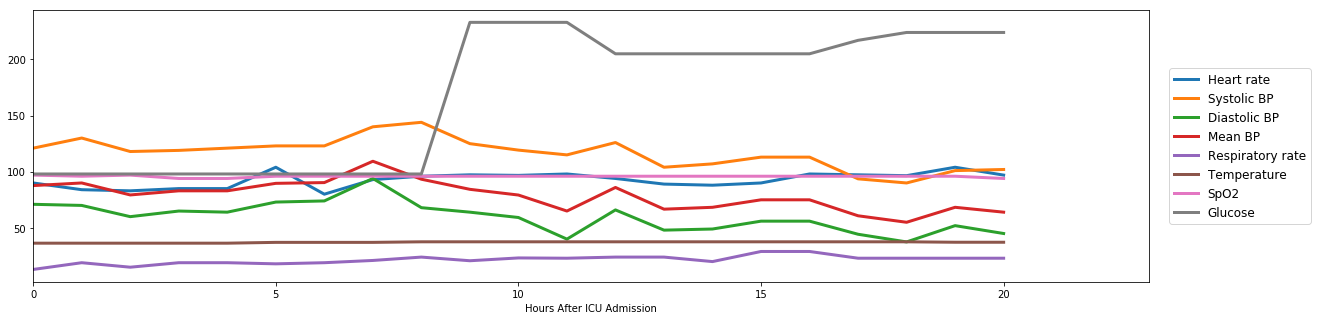

In [21]:
plot(200007)

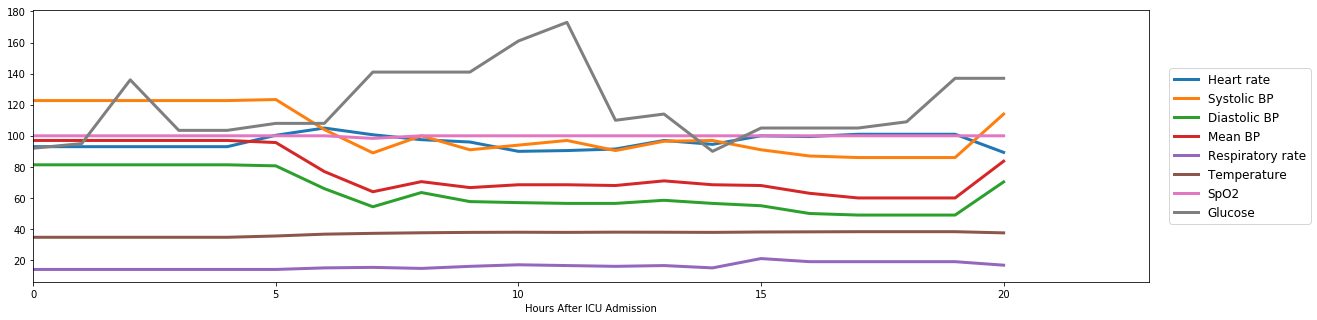

In [22]:
plot(200009)

## 7. Load data and labels

In [23]:
VARIABLES = ['heart_rate', 'sys_bp', 'dia_bp', 'mean_bp', 'resp_rate', 'temp', 'spo2', 'glucose']

ts_data = pd.read_csv('data/vitals.csv')
ts_data[:5]

,icustay_id,time,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,0,113.5,111.5,65.0,76.5,22.666667,37.277778,95.333333,118.0
1,200001,1,108.0,113.0,68.0,79.0,18.000000,37.277778,98.000000,118.0
2,200001,2,110.0,116.0,68.0,79.0,27.000000,37.277778,98.000000,118.0
3,200001,3,102.0,102.0,61.0,71.0,21.000000,37.666667,96.000000,118.0
4,200001,4,108.0,103.0,58.0,69.0,19.000000,37.666667,94.000000,118.0


In [24]:
ts_labels = pd.read_csv('data/vitals_labels.csv')
ts_labels[:5]

,icustay_id,label
0,280836,1
1,206613,0
2,220345,0
3,249196,0
4,210407,0


In [25]:
ts_data = ts_data.drop(columns=['time'])

## 8. Normalize features

Standardization: $x' = \frac{x - \bar{x}}{\sigma}$

Note: this should actually be done **after** the train/val/test split, calling .fit() on training values only, and then .transform() on all 3 sets. For this example, we're scaling based on all values, but in practice, the scaler should not know about the validation and test sets.

In [26]:
data = ts_data.copy()
for variable in VARIABLES:
    scaler = StandardScaler()
    data[variable] = scaler.fit_transform(data[variable].values.reshape(-1,1))

In [27]:
data[:5]

,icustay_id,heart_rate,sys_bp,dia_bp,mean_bp,resp_rate,temp,spo2,glucose
0,200001,1.037161,-0.348265,0.317805,-0.088839,0.690817,0.546693,-0.538583,-0.022463
1,200001,0.797887,-0.277900,0.529442,0.076864,-0.165601,0.546693,0.241495,-0.022463
2,200001,0.884896,-0.137170,0.529442,0.076864,1.486063,0.546693,0.241495,-0.022463
3,200001,0.536862,-0.793909,0.035623,-0.453384,0.384954,1.031733,-0.343563,-0.022463
4,200001,0.797887,-0.746999,-0.176014,-0.585947,0.017917,1.031733,-0.928621,-0.022463


## 9. Build dataset

#### Data dictionary: {icustay_id --> sequence}

In [28]:
data_dict = dict(data.groupby('icustay_id').apply(lambda group: group[VARIABLES].values))

In [29]:
data_dict[200381]

array([[ 1.2764338 ,  1.69231454,  0.38835094,  1.18155077, -0.16560095,
         0.06165535,  0.53402351,  0.04967756],
       [ 1.31993801,  1.87995403,  1.30544475,  1.84438108, -1.26671035,
         0.06165535,  0.53402351,  0.04967756],
       [ 1.66797174,  0.80102697, -0.66983421,  0.09895541,  0.38495376,
         0.06165535, -0.05103442,  0.04967756],
       [ 1.10241694,  0.94175659, -0.45819718,  0.29779859, -0.16560095,
         0.06165535, -0.05103442,  0.04967756],
       [ 1.31993801,  0.47265787, -0.3876515 ,  0.12105382, -0.16560095,
         0.06165535,  0.53402351,  0.04967756]])

In [30]:
data_dict[200381].shape

(5, 8)

In [31]:
data_dict[200001].shape

(24, 8)

#### Outcome dictionary: {icustay_id --> mortality label}

In [32]:
outcome_dict = dict([x for x in ts_labels[['icustay_id', 'label']].values])

In [33]:
outcome_dict[200001]

0

In [34]:
outcome_dict[280836]

1

#### Build X and y from dictionaries

In [35]:
icustay_ids = list(sorted(list(data_dict.keys())))

X = [data_dict[icustay_id] for icustay_id in icustay_ids]
y = np.array([outcome_dict[icustay_id] for icustay_id in icustay_ids])

## 10. Prepare input data

#### Pad sequences to uniform length (max sequence length)

In [36]:
sequence_lengths = [len(x) for x in X]
pd.Series(sequence_lengths).describe()

count    59248.000000
mean        20.791098
std          5.446613
min          1.000000
25%         21.000000
50%         23.000000
75%         24.000000
max         24.000000
dtype: float64

In [37]:
X_padded = pad_sequences(sequences=X,
                         maxlen=max(sequence_lengths),
                         padding='post',
                         truncating='pre',
                         value=999)
X_padded.shape

(59248, 24, 8)

#### Split into train, validation, and test sets

* 80% train, 20% test
* Use 20% of train for validation

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

print('# Train examples = %d' % len(y_train))
print('# Validation examples = %d' % len(y_val))
print('# Test examples = %d' % len(y_test))

# Train examples = 37918
# Validation examples = 9480
# Test examples = 11850


## 11. RNN (LSTM)

#### Model using Keras functional API

In [39]:
def build_model(lstm_units=64, dropout=0.2, input_shape=(24,8), mask_value=999, optimizer='adam'):
    model_input = Input(shape=input_shape)
    mask = Masking(mask_value=mask_value)(model_input)
    lstm = LSTM(units=lstm_units)(mask)
    dropout = Dropout(rate=dropout)(lstm)
    model_output = Dense(units=1, activation='sigmoid')(dropout)
    model = Model(model_input, model_output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### Build model

In [40]:
model = build_model()

#### Train model

In [41]:
model.fit(x=X_train,
          y=y_train,
          batch_size=256,
          epochs=5,
          validation_data=(X_val, y_val))

Train on 37918 samples, validate on 9480 samples
Epoch 1/5
37918/37918 [==============================] - 8s 218us/step - loss: 0.4396 - acc: 0.7801 - val_loss: 0.3877 - val_acc: 0.7742
Epoch 2/5
37918/37918 [==============================] - 7s 192us/step - loss: 0.3687 - acc: 0.8458 - val_loss: 0.3583 - val_acc: 0.8983
Epoch 3/5
37918/37918 [==============================] - 6s 169us/step - loss: 0.3560 - acc: 0.8705 - val_loss: 0.3428 - val_acc: 0.8970
Epoch 4/5
37918/37918 [==============================] - 7s 189us/step - loss: 0.3359 - acc: 0.8893 - val_loss: 0.3126 - val_acc: 0.8944
Epoch 5/5
37918/37918 [==============================] - 7s 194us/step - loss: 0.3285 - acc: 0.8927 - val_loss: 0.3262 - val_acc: 0.8963


## 12. Evaluation

#### Get prediction probabilities for test set

In [42]:
y_pred_proba = model.predict(X_test, batch_size=256).flatten()
y_pred_proba[:5]

array([0.02626532, 0.3542437 , 0.17709428, 0.15505192, 0.2001451 ],
      dtype=float32)

#### Round probabilities to get predicted class labels (0 or 1)

In [43]:
y_pred = np.round(y_pred_proba)
y_pred[:5]

array([0., 0., 0., 0., 0.], dtype=float32)

#### Test set results

In [44]:
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print('Test accuracy = %.3f' % accuracy)
print('Test AUC = %.3f' % auc)
print()
print(classification_report(y_test, y_pred))

Test accuracy = 0.898
Test AUC = 0.708

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     10541
           1       0.70      0.13      0.23      1309

   micro avg       0.90      0.90      0.90     11850
   macro avg       0.80      0.56      0.59     11850
weighted avg       0.88      0.90      0.87     11850



#### Check how many predictions were made of each class

In [45]:
pd.DataFrame(y_pred)[0].value_counts()

0.0    11597
1.0      253
Name: 0, dtype: int64

## 13. Model with class weighting

Scikit-learn 'balanced' = n_samples / (n_classes * np.bincount(y))

In [46]:
pd.Series(y).value_counts(normalize=True)

0    0.890275
1    0.109725
dtype: float64

In [47]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

array([0.56169822, 4.55198079])

In [48]:
class_weights = {i: class_weights[i] for i in [0,1]}
class_weights

{0: 0.5616982194175333, 1: 4.551980792316927}

In [49]:
model = build_model()

model.fit(x=X_train,
          y=y_train,
          batch_size=256,
          epochs=5,
          validation_data=(X_val, y_val),
          class_weight=class_weights)

Train on 37918 samples, validate on 9480 samples
Epoch 1/5
37918/37918 [==============================] - 8s 200us/step - loss: 0.6595 - acc: 0.6095 - val_loss: 0.6468 - val_acc: 0.6679
Epoch 2/5
37918/37918 [==============================] - 7s 182us/step - loss: 0.6236 - acc: 0.6283 - val_loss: 0.6252 - val_acc: 0.6806
Epoch 3/5
37918/37918 [==============================] - 7s 190us/step - loss: 0.5885 - acc: 0.7080 - val_loss: 0.5548 - val_acc: 0.7341
Epoch 4/5
37918/37918 [==============================] - 7s 173us/step - loss: 0.5799 - acc: 0.7184 - val_loss: 0.5886 - val_acc: 0.7238
Epoch 5/5
37918/37918 [==============================] - 7s 196us/step - loss: 0.5755 - acc: 0.7169 - val_loss: 0.5670 - val_acc: 0.7138


In [50]:
y_pred_proba = model.predict(X_test, batch_size=256)
y_pred = np.round(y_pred_proba)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print('Test accuracy = %.3f' % accuracy)
print('Test AUC = %.3f' % auc)
print()
print(classification_report(y_test, y_pred))

Test accuracy = 0.708
Test AUC = 0.773

              precision    recall  f1-score   support

           0       0.95      0.71      0.81     10541
           1       0.23      0.68      0.34      1309

   micro avg       0.71      0.71      0.71     11850
   macro avg       0.59      0.70      0.58     11850
weighted avg       0.87      0.71      0.76     11850



In [51]:
pd.DataFrame(y_pred)[0].value_counts()

0.0    7903
1.0    3947
Name: 0, dtype: int64

## 14. Callbacks

#### Value calculation (e.g. AUC) after each epoch

In [52]:
class AUCCallback(Callback):
    def __init__(self, val_data):
        super(AUCCallback, self).__init__()
        self.X_val, self.y_val = val_data
        
    def on_epoch_end(self, epoch, logs=None):
        y_pred_proba = self.model.predict(self.X_val, batch_size=256)
        auc = roc_auc_score(self.y_val, y_pred_proba)
        logs['val_auc'] = auc
        print('* Val AUC = %3f' % auc)

In [53]:
model = build_model()

auc_calculator = AUCCallback(val_data=(X_val, y_val))

model.fit(x=X_train,
          y=y_train,
          batch_size=256,
          epochs=5,
          validation_data=(X_val, y_val),
          class_weight=class_weights,
          callbacks=[auc_calculator])

Train on 37918 samples, validate on 9480 samples
Epoch 1/5
37918/37918 [==============================] - 7s 195us/step - loss: 0.6603 - acc: 0.5926 - val_loss: 0.7051 - val_acc: 0.6341
* Val AUC = 0.682516
Epoch 2/5
37918/37918 [==============================] - 7s 193us/step - loss: 0.6419 - acc: 0.6218 - val_loss: 0.6004 - val_acc: 0.6304
* Val AUC = 0.731607
Epoch 3/5
37918/37918 [==============================] - 7s 190us/step - loss: 0.6049 - acc: 0.6595 - val_loss: 0.6434 - val_acc: 0.6994
* Val AUC = 0.742208
Epoch 4/5
37918/37918 [==============================] - 8s 198us/step - loss: 0.5894 - acc: 0.7029 - val_loss: 0.5583 - val_acc: 0.7540
* Val AUC = 0.764076
Epoch 5/5
37918/37918 [==============================] - 7s 195us/step - loss: 0.5815 - acc: 0.7127 - val_loss: 0.5814 - val_acc: 0.6942
* Val AUC = 0.754997


#### Model checkpointing

In [54]:
checkpointer = ModelCheckpoint(filepath='model.hdf5', save_best_only=True)

#### Early stopping

In [55]:
early_stopper = EarlyStopping(monitor='val_loss', patience=3)

In [56]:
model = build_model()

ac = AUCCallback(val_data=(X_val, y_val))
mc = ModelCheckpoint(filepath='ts_model.hdf5', monitor='val_auc', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_auc', mode='max', patience=4)

model.fit(x=X_train,
          y=y_train,
          batch_size=256,
          epochs=1000000,
          validation_data=(X_val, y_val),
          class_weight=class_weights,
          callbacks=[ac, mc, es])

Train on 37918 samples, validate on 9480 samples
Epoch 1/1000000
37918/37918 [==============================] - 8s 214us/step - loss: 0.6474 - acc: 0.6135 - val_loss: 0.6571 - val_acc: 0.6084
* Val AUC = 0.726266
Epoch 2/1000000
37918/37918 [==============================] - 7s 181us/step - loss: 0.5990 - acc: 0.6813 - val_loss: 0.6318 - val_acc: 0.7036
* Val AUC = 0.738424
Epoch 3/1000000
37918/37918 [==============================] - 7s 186us/step - loss: 0.5875 - acc: 0.7013 - val_loss: 0.5863 - val_acc: 0.7103
* Val AUC = 0.770618
Epoch 4/1000000
37918/37918 [==============================] - 7s 181us/step - loss: 0.5793 - acc: 0.7187 - val_loss: 0.5631 - val_acc: 0.7273
* Val AUC = 0.760656
Epoch 5/1000000
37918/37918 [==============================] - 7s 187us/step - loss: 0.5706 - acc: 0.7245 - val_loss: 0.5920 - val_acc: 0.7136
* Val AUC = 0.772701
Epoch 6/1000000
37918/37918 [==============================] - 7s 179us/step - loss: 0.5739 - acc: 0.7026 - val_loss: 0.5893 - val_